In [23]:
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility
import numpy as np
import torch
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import view_points, box_in_image
import numpy as np

# 初始化 nuScenes 对象
nusc = NuScenes(version='v1.0-mini', dataroot='../data/nuscenes', verbose=True)


X, Y, Z, W, L, H, SIN_YAW, COS_YAW, VX, VY, VZ = list(range(11))  # undecoded
CNS, YNS = 0, 1  # centerness and yawness indices in quality
YAW = 6  # decoded

classes = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker','vehicle.car','vehicle.bicycle']
pedestrians = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker'] 

def box3d_to_corners(box3d):
    if isinstance(box3d, torch.Tensor):
        box3d = box3d.detach().cpu().numpy()
    corners_norm = np.stack(np.unravel_index(np.arange(8), [2] * 3), axis=1)
    corners_norm = corners_norm[[0, 1, 3, 2, 4, 5, 7, 6]]
    # use relative origin [0.5, 0.5, 0]
    corners_norm = corners_norm - np.array([0.5, 0.5, 0.5])
    corners = box3d[:, None, [W, L, H]] * corners_norm.reshape([1, 8, 3])

    # rotate around z axis
    rot_cos = np.cos(box3d[:, YAW])
    rot_sin = np.sin(box3d[:, YAW])
    rot_mat = np.tile(np.eye(3)[None], (box3d.shape[0], 1, 1))
    rot_mat[:, 0, 0] = rot_cos
    rot_mat[:, 0, 1] = -rot_sin
    rot_mat[:, 1, 0] = rot_sin
    rot_mat[:, 1, 1] = rot_cos
    corners = (rot_mat[:, None] @ corners[..., None]).squeeze(axis=-1)
    corners += box3d[:, None, :3]
    return corners


def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image info


def view_points(points: np.ndarray, view: np.ndarray, normalize: bool) -> np.ndarray:

    assert view.shape[0] <= 4
    assert view.shape[1] <= 4
    assert points.shape[0] == 3

    viewpad = np.eye(4)
    viewpad[:view.shape[0], :view.shape[1]] = view

    nbr_points = points.shape[1]

    # Do operation in homogenous coordinates.
    points = np.concatenate((points, np.ones((1, nbr_points))))
    points = np.dot(viewpad, points)
    points = points[:3, :]

    if normalize:
        points = points / points[2:3, :].repeat(3, 0).reshape(3, nbr_points)

    return points

def threeD_2_twoD(boxsy,intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
   
    
    return min_x,max_x,min_y,max_y



def all_3d_to_2d(boxes,anns,intrinsic): #input 3d boxes, annotation key lists, intrinsic matrix (one image)
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    x_min_3d = []
    x_max_3d = []
    y_min_3d = []
    y_max_3d = []
    center_3d = []
    width=[]
    height=[]
    objects_detected =[]
    orig_objects_detected =[]
    
   
    for j in range(len(boxes)): #iterate through boxes
        box=boxes[j]
        
        if box.name in classes: #if the box.name is in the classes we want to detect
        
            if box.name in pedestrians: 
                orig_objects_detected.append("pedestrian")
            elif box.name == "vehicle.car":
                orig_objects_detected.append("car")
            else:
                orig_objects_detected.append("cyclist")
            #print(box)
            
            visibility = nusc.get('sample_annotation', '%s' %anns[j])['visibility_token'] #give annotation key
            visibility = int(visibility)

            
            if visibility > 1: #more than 40% visible in the panoramic view of the the cameras

                    
                center = box.center #get boxe's center

                center = np.dot(intrinsic,center)
                center_point = center/(center[2]) #convert center point into image plane
                
                
                
                
                if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
                    #if center of bounding box is outside of the image, do not annotate
                    pass
                
                else:
                    min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
                    w = max_x - min_x
                    h = max_y - min_y
        
                    
                    x_min.append(min_x)
                    x_max.append(max_x)
                    y_min.append(min_y)
                    y_max.append(max_y)

                    x_min_3d.append(box.center[0]-box.wlh[0]/2)
                    x_max_3d.append(box.center[0]+box.wlh[0]/2)
                    y_min_3d.append(box.center[2]-box.wlh[2]/2)
                    y_max_3d.append(box.center[2]+box.wlh[2]/2)
                    center_3d.append(box.center)

                    width.append(w)
                    height.append(h)
                    if box.name in pedestrians: 
                        objects_detected.append("pedestrian")
                    elif box.name == "vehicle.car":
                        objects_detected.append("car")
                    else:
                        objects_detected.append("cyclist")
                    

            else:
                pass

    return x_min,x_max,y_min,y_max,width,height,objects_detected,orig_objects_detected, [x_min_3d, x_max_3d, y_min_3d, y_max_3d, center_3d] #for a single image

def extract_bounding_box(i,camera_name): #give a single sample number and camera name
    
    '''
    input sample number i, camera name
    outputs min x, max x, min y max y, width and height of bounding box in image coordinates
    2d bounding box
    options for camera name : CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT,CAM_BACK_LEFT
    '''
    
    nusc.sample[i] #one image
    
    camera_token = nusc.sample[i]['data']['%s' %camera_name] #one camera, get the camera token 

    path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %camera_token) #gets data for one image
    
    x_min, x_max,y_min,y_max,width,height, objects_detected,orig_objects_detected, box_3d_coord = all_3d_to_2d(boxes,anns, intrinsic_matrix)
    
    return x_min, x_max, y_min, y_max, width, height, path, boxes,intrinsic_matrix, objects_detected,orig_objects_detected, box_3d_coord
    #info for a single image
    

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.453 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [133]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
SCALE = 5
box_h_arr = []
box_ym_arr = []
distance_arr = []

box_x_offset = []
box_y_offset = [] # bbox bottom and image bottom distance

horizon_offset = []

obj_all_frame_dict = {}


for i in range(nusc.sample.__len__()):
    obj_cur_frame_dict = {}
    frame = extract_bounding_box(i, 'CAM_FRONT')

    # img = cv2.imread(frame[6])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plt.figure(figsize=(10, 10))
    # for x_min, x_max, y_min, y_max in zip(frame[0], frame[1], frame[2], frame[3]):
    #     cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
    # plt.imshow(img)
    # plt.show()
    

    # img_bev = np.zeros((1000, 1000, 3), dtype=np.uint8)
    # img_bev = cv2.circle(img_bev, (img_bev.shape[0] // 2, img_bev.shape[0] // 2), 5, (255, 255, 255), -1)
    
    for j, (x_min, x_max, y_min, y_max, center_3d, box_h, obj_name) in enumerate(zip(frame[0], frame[1], frame[2], frame[3], frame[-1][4], frame[5], frame[9])):
        # x_min : 2d bbox x_min
        # x_max : 2d bbox x_max
        # y_min : 2d bbox y_min
        # y_max : 2d bbox y_max

        if obj_name == 'pedestrian':
            color = (0, 255, 0)
            
        elif obj_name == 'car':
            x_min = 900 if x_min > 1600 else x_min
            x_max = 900 if x_max > 1600 else x_max
            y_min = 900 if y_min > 900 else y_min
            y_max = 900 if y_max > 900 else y_max

            color = (255, 0, 0)
            box_h_arr.append(box_h)
            box_ym_arr.append(y_max - y_min)
            distance_arr.append(center_3d[2] * SCALE) # BEV 下的y座標

            box_x_offset.append( ((x_min + x_max) // 2) - 800)
            box_y_offset.append(900 - y_max)
            horizon_offset.append(center_3d[0] * SCALE) # BEV 下的x座標


        else:
            color = (0, 0, 255)
        # cv2.rectangle(img_bev, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
        # cv2.circle(img_bev, (int(center_3d[0] * SCALE + img_bev.shape[0] // 2), -int(center_3d[2]) * SCALE + img_bev.shape[1] // 2), 3, color, -1)
        # save x, y, w, h, cls
        obj_cur_frame_dict[str(j)] = {'x': int(x_min), 'y': int(y_min), 'w': int(x_max - x_min), 'h': int(y_max - y_min), 'cls': obj_name}
    obj_all_frame_dict[str(i)] = obj_cur_frame_dict
        
    # plt.imshow(img)
    # plt.show()
    # plt.figure(figsize=(7, 7))
    # plt.imshow(img_bev)
    # plt.show()
 
# with open('2d_bbox.json', 'w') as f:
#     json.dump(obj_all_frame_dict, f)

### ================== 以上為獲取資料 ==================

### ================== 以下為處理 BEV y 軸 (distance) ==================

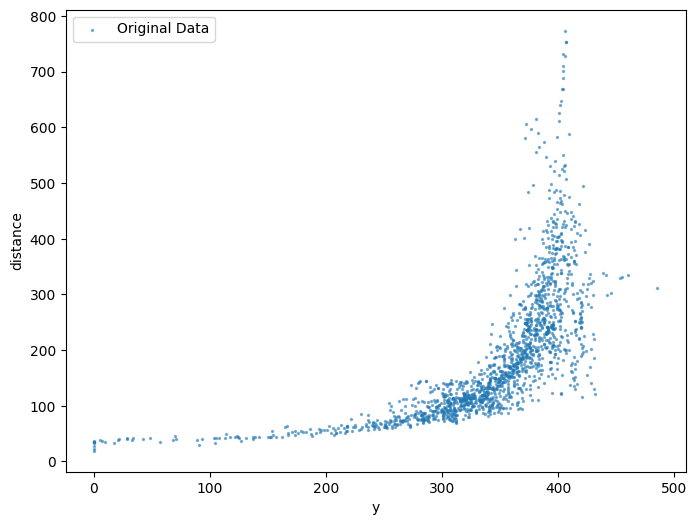

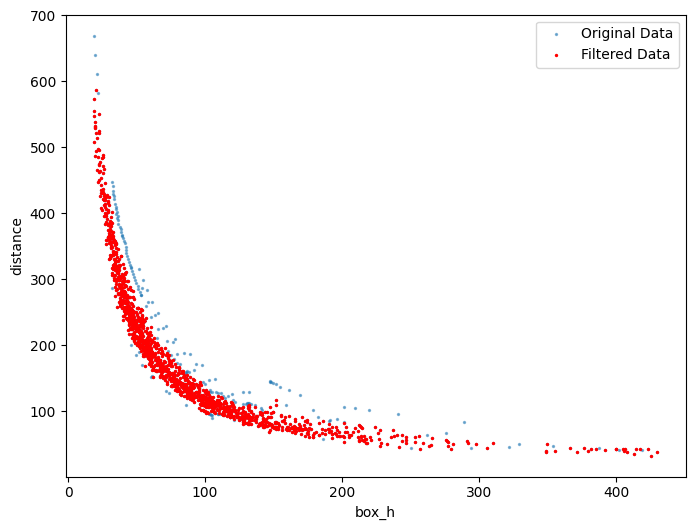

In [136]:
# cat list on dim 1
box_h_arr = np.array(box_h_arr)
distance_arr = np.array(distance_arr)
img_bottom_arr = np.array(box_y_offset)

plt.figure(figsize=(8, 6))
plt.scatter(img_bottom_arr, distance_arr, label='Original Data', s=2, alpha=0.5)
plt.xlabel('y')
plt.ylabel('distance')
plt.legend()
plt.show()

combined_arr = np.concatenate([box_h_arr[:, None], distance_arr[:, None]], axis=1)
combined_arr = np.array(sorted(combined_arr, key=lambda x: x[0]))

# 計算 box_h 離群值
top = np.percentile(box_h_arr, 99)
bottom = np.percentile(box_h_arr, 1)

combined_arr = combined_arr[(combined_arr[:, 0] > bottom) & (combined_arr[:, 0] < top)]

window_size = 5

x = combined_arr[:, 0]
y = combined_arr[:, 1]

# 儲存過濾後的數據
x_filtered = []
y_filtered = []

# 遍歷每個數據點，計算局部中位數
for i in range(len(x)):
    # 計算鄰近範圍的索引
    lower_bound = x[i] - window_size
    upper_bound = x[i] + window_size

    # 找出 x 在此範圍內的索引
    indices = np.where((x >= lower_bound) & (x <= upper_bound))[0]

    # 計算鄰近距離的中位數和標準差
    local_median = np.median(y[indices])
    local_std = np.std(y[indices])

    # 判斷當前點是否偏離局部中位數（例如 2 個標準差以上）
    if np.abs(y[i] - local_median) < 1.5 * local_std:
        x_filtered.append(x[i])
        y_filtered.append(y[i])

# 將過濾後的數據轉換為 numpy 陣列
x_filtered = np.array(x_filtered)
y_filtered = np.array(y_filtered)


plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Original Data', s=2, alpha=0.5)
plt.scatter(x_filtered, y_filtered, color='red', label='Filtered Data', s=2)
plt.xlabel('box_h')
plt.ylabel('distance')
plt.legend()
plt.show()



(1571, 1)

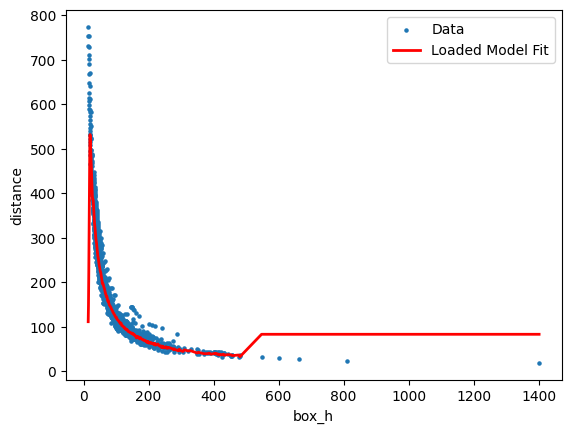

In [70]:
import joblib
# 從檔案載入模型
loaded_tree_reg = joblib.load('svr_rbf_model.joblib')


# 使用載入的模型進行預測
y_fit_loaded = loaded_tree_reg.predict(combined_arr[:, 0].reshape(-1, 1))

x = combined_arr[:, 0]
y = combined_arr[:, 1]

distance = combined_arr[:, 0].reshape(-1, 1)

# 繪製原始數據點和載入後的模型擬合曲線
plt.scatter(x, y, label='Data', s=5)
plt.plot(combined_arr[:, 0].reshape(-1, 1), y_fit_loaded, color='r', label='Loaded Model Fit', linewidth=2)
plt.xlabel('box_h')
plt.ylabel('distance')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# 假設已有數據 x 和 y，分別代表 box_h 和 distance
# x = x_filtered
# y = y_filtered
x = combined_arr[:, 0]
y = combined_arr[:, 1]

# 將 x 轉換成 2D 陣列以符合 scikit-learn 的輸入要求
x = x.reshape(-1, 1)

# 建立 SVR 模型，使用 RBF 核函數
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1)
svr_rbf.fit(x, y)

# 使用訓練好的模型進行預測
x_fit = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_fit = svr_rbf.predict(x_fit)

# 繪製原始數據點和 SVR 擬合曲線
plt.scatter(x, y, label='Data', s=5, alpha=0.5)
plt.plot(x_fit, y_fit, color='red', label='SVR Fit', linewidth=2)
plt.xlabel('box_h')
plt.ylabel('distance')
plt.legend()
plt.show()


### ================== 以下處裡 BEV x軸 (橫向) ==================

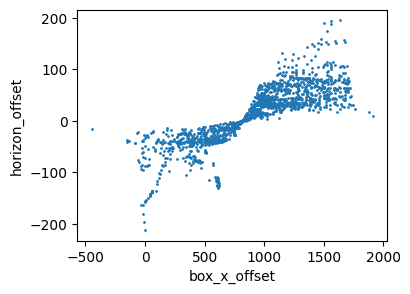

In [57]:
plt.figure(figsize=(4, 3))
plt.scatter(box_x_offset, horizon_offset, s=1)
plt.xlabel('box_x_offset')
plt.ylabel('horizon_offset')
plt.show()

In [13]:
# x 軸的預測資料預處理

# cat list on dim 1

data_arr = np.array([box_h_arr, box_x_offset, horizon_offset]).T



# combined_arr = np.concatenate([box_h_arr[:, None], distance_arr[:, None]], axis=1)
# combined_arr = np.array(sorted(combined_arr, key=lambda x: x[0]))

# # 計算 box_h 離群值
top = np.percentile(box_h_arr, 99)
bottom = np.percentile(box_h_arr, 1)

data_arr = data_arr[(data_arr[:, 0] > bottom) & (data_arr[:, 0] < top)]

# window_size = 5
inputs = data_arr[:, :2]
labels = data_arr[:, 2]


In [14]:
labels.shape

(93330,)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
import joblib


# 假設已有數據 x 和 y，分別代表 box_h 和 distance
# x = x_filtered
# y = y_filtered
x = inputs
y = labels
x1 = inputs[:, 0]
x2 = inputs[:, 1]
# 將 x 轉換成 2D 陣列以符合 scikit-learn 的輸入要求
# x = x.reshape(-1, 1)

# 建立 SVR 模型，使用 RBF 核函數
xsvr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, verbose=True)
xsvr_rbf.fit(x, y)
joblib.dump(xsvr_rbf, '3d_x_svr_rbf_model.joblib')

x1_fit = np.linspace(min(x1), max(x1), 50)
x2_fit = np.linspace(min(x2), max(x2), 50)
x1_fit, x2_fit = np.meshgrid(x1_fit, x2_fit)
x_fit = np.vstack([x1_fit.ravel(), x2_fit.ravel()]).T

# # 預測這些點的 y 值
# y_fit = svr_rbf.predict(x_fit)

# # 將結果轉換為網格形式以便於繪製
# y_fit = y_fit.reshape(x1_fit.shape)


# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')



[LibSVM].............

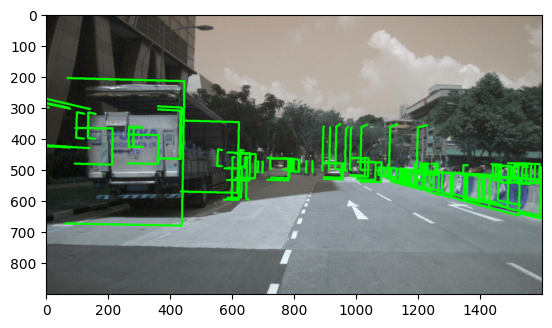

In [58]:
sample_token = nusc.sample[0]['token']  # 替換為你的 sample token
sample = nusc.get('sample', sample_token)

# 選擇相機的 sample_data (例如, 'CAM_FRONT')
camera_token = sample['data']['CAM_FRONT']
camera_data = nusc.get('sample_data', camera_token)

# 載入影像
image_path = nusc.get_sample_data_path(camera_token)
image = cv2.imread(image_path)

# 取得相機校準資料
calibrated_sensor = nusc.get('calibrated_sensor', camera_data['calibrated_sensor_token'])
ego_pose = nusc.get('ego_pose', camera_data['ego_pose_token'])

def threeD_2_twoD2(x, y, z, intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]

    return perspective_x, perspective_y, perspective_z

def twoD_2_threeD2(x_2d, y_2d, z, intrinsic):  # input is a 2D point and depth value
    '''
    Given 2D points, a depth value, and an intrinsic camera matrix,
    outputs the 3D point coordinates.
    '''
    # Create a 3D point in homogeneous coordinates
    x_y_z = np.array([x_2d * z, y_2d * z, z])

    # Compute the inverse of the intrinsic matrix
    intrinsic_inv = np.linalg.inv(intrinsic)

    # Transform the 2D point back into 3D space
    x_y_z_3d = np.dot(intrinsic_inv, x_y_z)

    # Extract the 3D coordinates
    x_3d, y_3d, z_3d = x_y_z_3d

    return x_3d, y_3d, z_3d

# 擷取該幀的所有標註
anns = sample['anns']
for ann_token in anns:
    ann = nusc.get('sample_annotation', ann_token)
    
    # 取得 Box 物件
    box = Box(
        center=ann['translation'],
        size=ann['size'],
        orientation=Quaternion(ann['rotation'])
    )
    
    # 將 box 從世界座標轉換到相機座標
    # 1. 將 box 移動到 ego car 座標系
    box.translate(-np.array(ego_pose['translation']))
    box.rotate(Quaternion(ego_pose['rotation']).inverse)
    
    # 2. 將 box 移動到相機座標系
    box.translate(-np.array(calibrated_sensor['translation']))
    box.rotate(Quaternion(calibrated_sensor['rotation']).inverse)
    
    # 判斷 box 是否在相機視角內，如果是，則繪製到影像上
    camera_intrinsic = np.array(calibrated_sensor['camera_intrinsic'])
 
    # box.render_cv2(image, view=camera_intrinsic, normalize=True)
    corners = box.corners()
    x_ori = corners[0,:]
    y_ori = corners[1,:]
    z_ori = corners[2,:]
    x_arr, y_arr, z_arr = threeD_2_twoD2(x_ori, y_ori, z_ori, camera_intrinsic)
    for i, (x, y) in enumerate(zip(x_arr, y_arr)):
        x = int(x)
        y = int(y)
        if i != 0:
            if i != 4:
                image = cv2.line(image, (prev_x, prev_y), (x, y), (0, 255, 0), 5)
           
        prev_x = x
        prev_y = y


# 顯示並保存影像
plt.imshow(image)

In [65]:
print(twoD_2_threeD2(x_arr, y_arr, z_arr * 12, camera_intrinsic))
print(x_ori, y_ori, z_ori)

(array([6.7756497 , 5.83433044, 5.80612993, 6.7414288 , 7.43291434,
       6.39734081, 6.36843264, 7.39772928]), array([0.36948332, 0.29093251, 1.23993204, 1.4757402 , 0.38435734,
       0.30363755, 1.25321734, 1.49140279]), array([12., 12., 12., 12., 12., 12., 12., 12.]))
[6.76481966 6.79232766 6.76778505 6.74027705 7.41559744 7.44310543
 7.41856282 7.39105483] [0.36889275 0.33870364 1.44529896 1.47548808 0.38346188 0.35327277
 1.45986809 1.49005721] [11.98081948 13.97040033 13.98753069 11.99794985 11.97204288 13.96162372
 13.97875409 11.98917325]


In [88]:
nusc_object = nusc

sd_record = nusc_object.get('sample_data', nusc.sample[0]['data']['CAM_FRONT'])
cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])


cam_intrinsic = np.array(cs_record['camera_intrinsic'])


def twoD_2_threeD(point,intrinsic): #input is a single annotation box

    x - point[0]
    y = point[1]
    z = 1
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(np.linalg.inv(intrinsic),x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
   
    
    return perspective_x,perspective_y


def rotate_2d_point(x, y, theta):

    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Original point as a column vector
    point = np.array([x, y])

    # Apply the rotation matrix to the point
    rotated_point = np.dot(rotation_matrix, point)

    # Extract the rotated coordinates
    x_rotated, y_rotated = rotated_point

    return x_rotated, y_rotated

In [ ]:
import joblib
svg_rbf_model = joblib.load('svr_rbf_model.joblib')
x_svg_rbf_model = joblib.load('3d_x_svr_rbf_model.joblib')

for i, cur_frame_data in enumerate(obj_all_frame_dict.values()):
    if i < 40:
        continue
    if i > 50:
        break
    plt.figure(figsize=(10, 10))
    frame = extract_bounding_box(i, 'CAM_FRONT')
    img_front = cv2.imread(frame[6])
    img_front = cv2.cvtColor(img_front, cv2.COLOR_BGR2RGB)
    tmp_dict = {'obj':[]}
    for it in cur_frame_data.values():
        tmp_dict['obj'].append(it)
    inputs = np.array([it['h'] for it in tmp_dict['obj'] if it['cls'] == 'car'])
    inputs_3d_x = np.array([inputs.tolist(), [(it['x'] + it['w']) // 2 - 800 for it in tmp_dict['obj'] if it['cls'] == 'car']]).T
    if inputs.shape[0] != 0:
        distance_arr = svg_rbf_model.predict(inputs.reshape(-1, 1)).flatten()
        x_offset_arr = x_svg_rbf_model.predict(inputs_3d_x).flatten() 
    
    car_idx = 0
    # 估計的 3D bbox
    img = np.zeros((400, 400, 3), dtype=np.uint8)
    img = cv2.circle(img, (img.shape[0] // 2, img.shape[0] // 2), 2, (255, 0, 255), -1)
    for idx, obj in enumerate(tmp_dict['obj']):
        if obj['cls'] == 'car':
      
            SCALE = 2
            x = obj["x"]
            y = obj["y"]
            w = obj["w"]
            h = obj["h"]
            # x = (x + w) / 2 # 2d bbox 中心 x 座標
            # x = (x - 800) * 0.1 #* 70 - 35

            # y = -distance_arr[car_idx] * 100
            # # x = x_offset_arr[car_idx]
            
            print(distance_arr[car_idx])
            x, y, z = twoD_2_threeD2((x + w) // 2, y + h, distance_arr[car_idx] / 5, cam_intrinsic)
            x, z = rotate_2d_point(x, z, -(np.pi / 180) * 20)
            # x = x * 20
            # y = y * 20
            print(x, y, z)
            img = cv2.circle(img, (int(x + img.shape[0] // 2), int(-z + img.shape[0] // 2)), 2, (255, 0, 0), -1)
    
            car_idx += 1


    # set 1 of 2 image in the row
    # plt.subplot(1, 2, 1)
    # plt.imshow(img)

    # BEV視角GT
    img_2 = np.zeros((400, 400, 3), dtype=np.uint8)
    img_2 = cv2.circle(img_2, (img_2.shape[0] // 2, img_2.shape[0] // 2), 2, (255, 0, 255), -1)
    for j, (x_min_3d, x_max_3d, y_min_3d, y_max_3d, center_3d, obj_name) in enumerate(zip(frame[-1][0], frame[-1][1], frame[-1][2], frame[-1][3], frame[-1][4], frame[9])):
        x_min_3d = int(x_min_3d) + img_2.shape[0] // 2
        x_max_3d = int(x_max_3d) + img_2.shape[0] // 2
        y_min_3d = -int(y_min_3d) + img_2.shape[1] // 2
        y_max_3d = -int(y_max_3d) + img_2.shape[1] // 2
        center_3d = (int(center_3d[0]) + img_2.shape[0] // 2, -int(center_3d[2]) + img_2.shape[1] // 2)
        if obj_name == 'car':
            # print(center_3d)
            
            img = cv2.circle(img, center_3d, 2, (0, 255, 0), -1)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_front)
    plt.show()

